# German Traffic Sign Classifier using a LeNet based Convolutional Network
---

In [1]:
# here goes project description

# Import Required Libraries

In [36]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [37]:
TRAIN_IMAGE_DIR = 'data/Final_Training/Images'
# root_dir = '../Datasets/GTSRB/Final_Training/Images/'

dfs = []
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('/')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [38]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,data/Final_Training/Images/00031/00000_00000.ppm,38,35,5,5,33,30,31
1,data/Final_Training/Images/00031/00000_00001.ppm,40,36,6,5,34,31,31
2,data/Final_Training/Images/00031/00000_00002.ppm,40,37,5,5,34,32,31
3,data/Final_Training/Images/00031/00000_00003.ppm,41,39,6,6,36,34,31
4,data/Final_Training/Images/00031/00000_00004.ppm,43,37,6,5,38,32,31


In [39]:
train_df["Filename"][0]

'data/Final_Training/Images/00031/00000_00000.ppm'

**Annotation format**

- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label

**The following points are worth mentioning:**

- Image sizes are not fixed
- Sign sizes are not fixed
- Sign's center location is not fixed <br>
`Later on, I'll examine sample images to further clarify those points.`

### Class Distribution
There are 43 traffic sign classes in 39,209 training images.

In [40]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


`The distribution of classes are very skewed.`

In [41]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

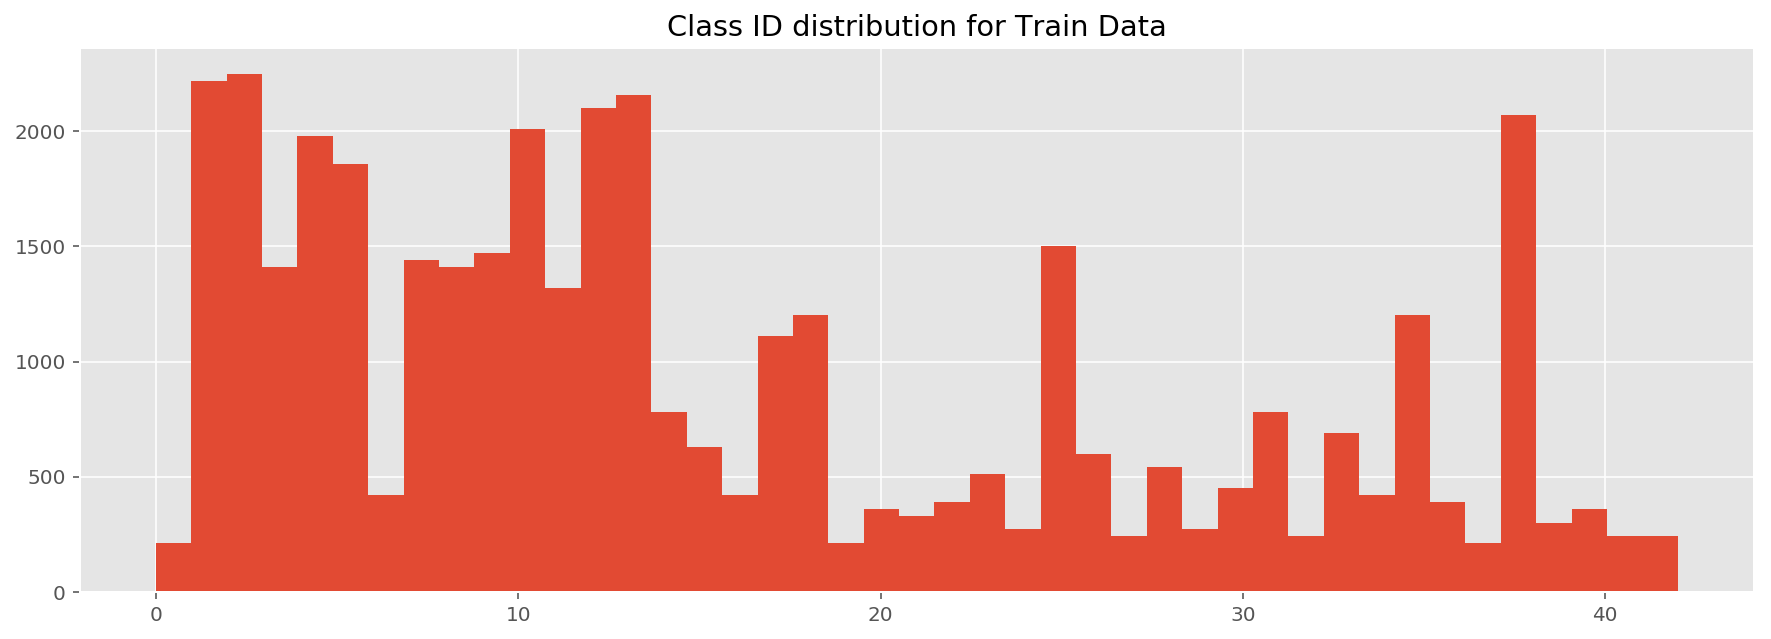

In [42]:
show_class_distribution(train_df['ClassId'], 'Train Data')

The name of each sign are stored in sign_names.csv file. We can use it see the distribution per sign names.

In [43]:
sign_name_df = pd.read_csv('sign_names.csv', index_col='ClassId')
sign_name_df.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [44]:
# visualizing number of occurances of each sign as the samples are skewed

In [45]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)


,SignName,Occurence
ClassId,,
2,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
13,Yield,2160
12,Priority road,2100
38,Keep right,2070
10,No passing for vehicles over 3.5 metric tons,2010
4,Speed limit (70km/h),1980
5,Speed limit (80km/h),1860
25,Road work,1500


**This constant will be used later** 

In [46]:
SIGN_NAMES = sign_name_df.SignName.values
SIGN_NAMES[2]

'Speed limit (50km/h)'

### Sample Images
Let's examine some random images:

In [47]:
def load_image(image_file):
    """
    Read image file into numpy array (RGB)
    """
    return plt.imread(image_file)



In [48]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [49]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

The below are 20 random sample images from the train set.

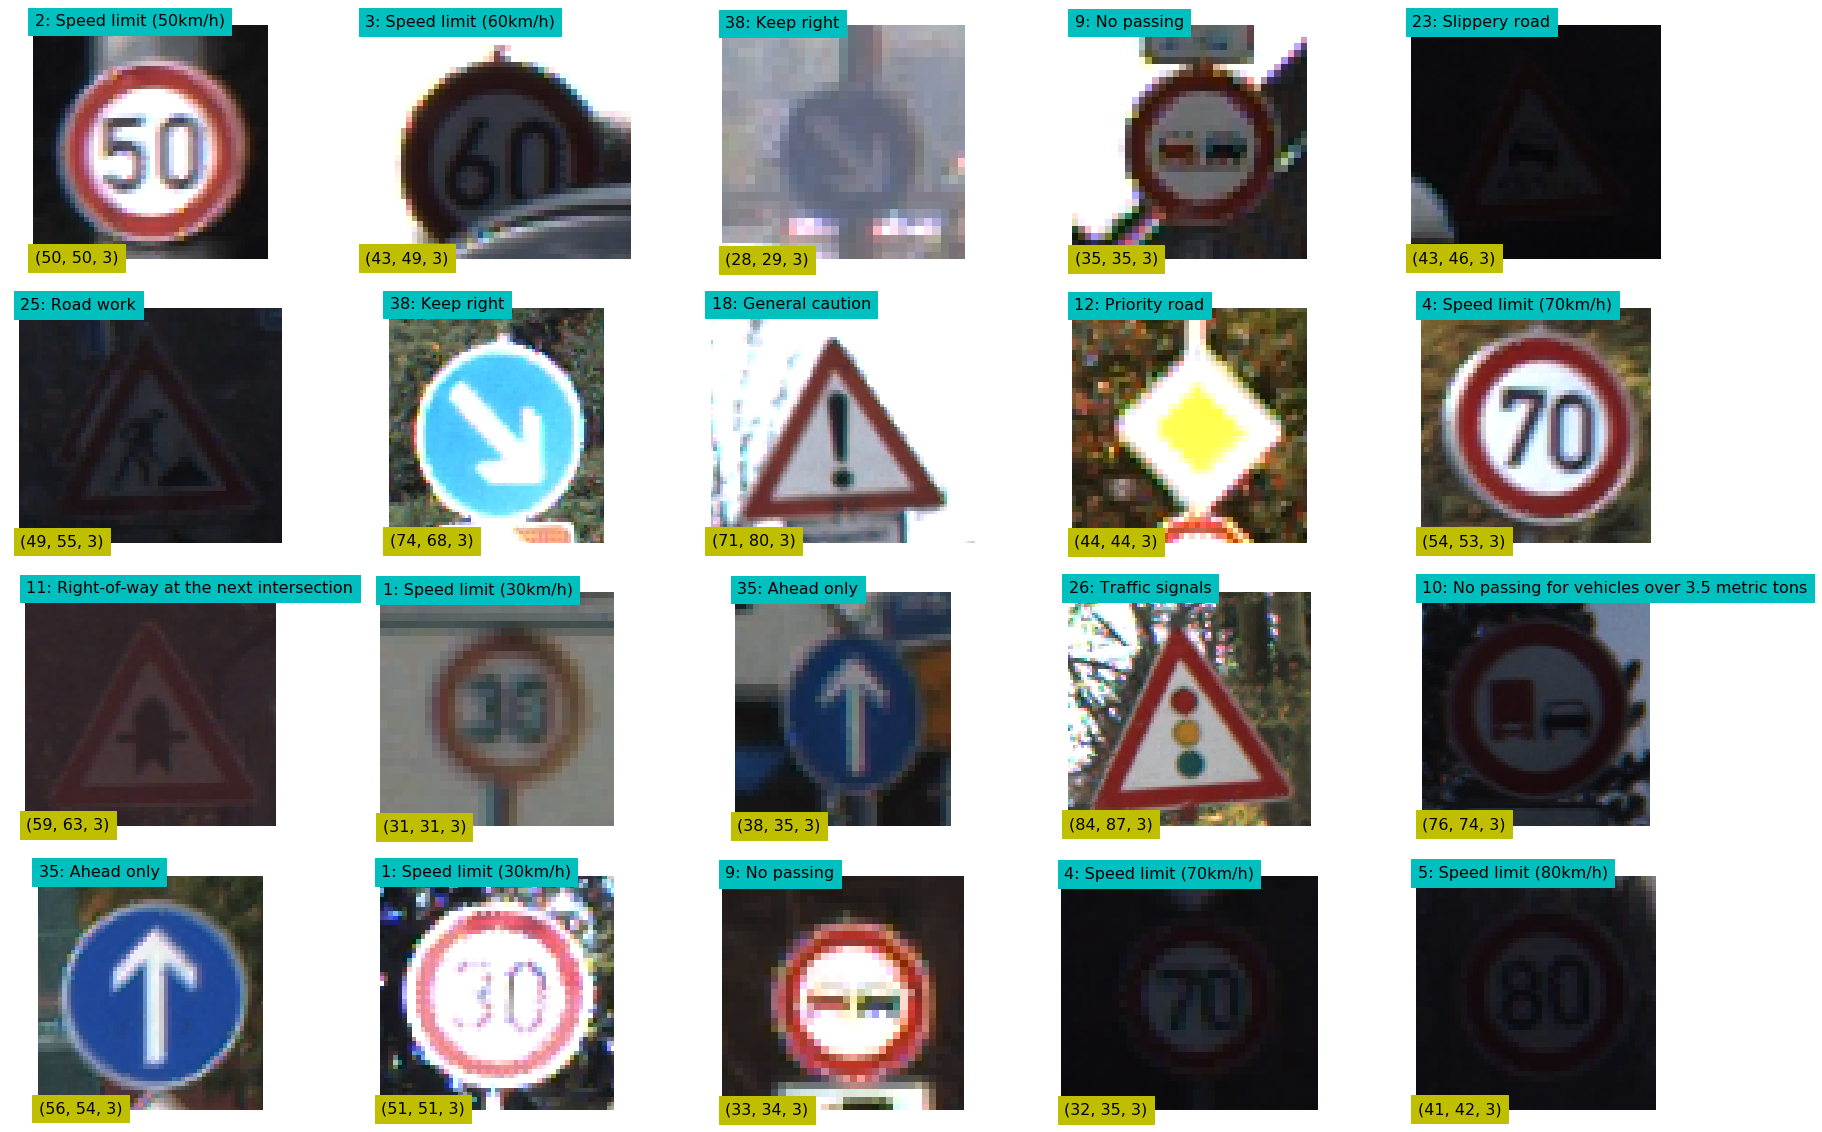

In [51]:
sample_data = get_samples(train_df, 20)
sample_data
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)